# Introduction

This notebook presents **bag-of-words** sentiment anlysis on [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/) movie reviews dataset in Keras.

**Contents**

* [IMDB Dataset](#IMDB-Dataset) - load and preprocess
* [PyTorch Model](#Keras-Model) - build and train model

# Imports

In [15]:
import os
import re
import collections
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Pick GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# IMDB Dataset

Download the dataset from [here](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and extract. Point path below to extracted location.

In [3]:
dataset_location = '/home/marcin/Datasets/imdb'

Helper to load the dataset

In [4]:
def load_imdb_dataset(dataset_loc):
    def read_reviews(path, label, reviews, labels):
        files_list = sorted(os.listdir(path))
        for filename in sorted(os.listdir(path)):
            with open(os.path.join(path, filename)) as f:
                reviews.append(f.read())
                labels.append(label)
        return reviews, labels
    
    path_train_pos = os.path.join(dataset_location, 'aclImdb_v1/aclImdb/train/pos')
    path_train_neg = os.path.join(dataset_location, 'aclImdb_v1/aclImdb/train/neg')
    path_test_pos = os.path.join(dataset_location, 'aclImdb_v1/aclImdb/test/pos')
    path_test_neg = os.path.join(dataset_location, 'aclImdb_v1/aclImdb/test/pos')
    
    train_revs, train_labels = [], []
    train_revs, train_labels = read_reviews(path_train_pos, 1, train_revs, train_labels)
    train_revs, train_labels = read_reviews(path_train_neg, 0, train_revs, train_labels)
    
    test_revs, test_labels = [], []
    test_revs, test_labels = read_reviews(path_test_pos, 1, test_revs, test_labels)
    test_revs, test_labels = read_reviews(path_test_neg, 0, test_revs, test_labels)
    
    return (train_revs, train_labels), (test_revs, test_labels)

In [5]:
(reviews_raw, labels_raw), (test_reviews_raw, test_labels_raw) = \
    load_imdb_dataset(dataset_location)

In [6]:
reviews_raw[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

# Preprocess Data

We are going to perform following pre-processing steps:

* text cleanup - convert to lowercase and remove any non __a-z__ characters
* reduce vocabulary - keep 1000 most common words (same as tf.keras.datasets.imbd)
* tokenize - convert words to ints

**Text Cleanup**

We are going to perform following pre-processing steps:

* convert to lowercase
* keep only a-z characters, convert everything else to space
  * (we could spell digits, i.e. convert 20 to 'two zero' but we won't bother here)
* split whatever is left thus removing any consequent spaces
  
This will leave us with dataset build of 26 letters.

Note that words like "didn't" will be converted to "didn t", but that's ok. Words "did" and "didn" will still be encoded as different characters. Word "t" can be dropped when removing stopwords.

In [12]:
regex = re.compile('[^a-z ]+')

def cleanup(text):
    res = text.lower()
    res = regex.sub(' ', res)
    return res.split()

reviews = []
for rev in reviews_raw:
    reviews.append(cleanup(rev))
    
test_reviews = []
for test_rev in test_reviews_raw:
    test_reviews.append(cleanup(test_rev))

In [13]:
print(reviews[0])

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life', 'such', 'as', 'teachers', 'my', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', 'high', 's', 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', 'teachers', 'the', 'scramble', 'to', 'survive', 'financially', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', 'teachers', 'pomp', 'the', 'pettiness', 'of', 'the', 'whole', 'situation', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school', 'i', 'immediately', 'recalled', 'at', 'high', 'a', 'classic', 'line', 'inspector', 'i', 'm', 'here', 'to', 'sack', 'one', 'of', 'your', 'teachers', 'student', 'welcome', 'to', 'bromw

In [16]:
words_counter = collections.Counter()
for review in reviews:
    words_counter.update(review)

In [17]:
print('Total words: ', sum(list(words_counter.values())))
print('Unique words:', len(words_counter))

Total words:  6023662
Unique words: 73272


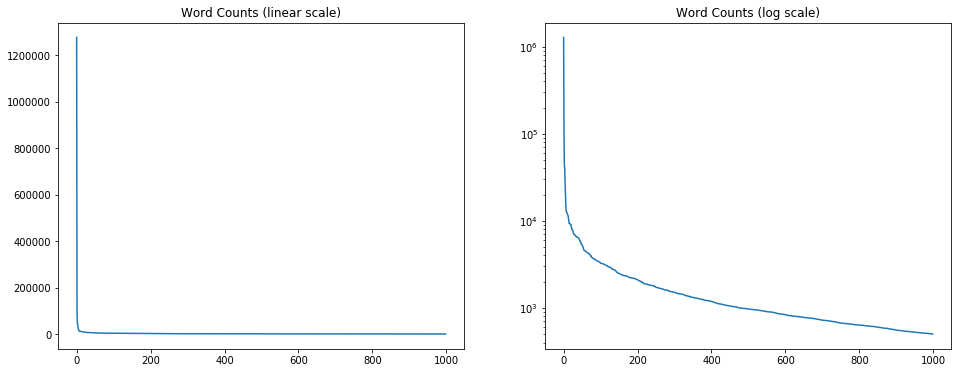

In [80]:
def plot_counts(words_counter, title):
    sorted_all = np.array(sorted(list(words_counter.values()), reverse=True))
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[16,6])
    ax1.plot(sorted_all); ax1.set_title(title + ' Counts (linear scale)')
    ax2.plot(sorted_all); ax2.set_title(title + ' Counts (log scale)')
    ax2.set_yscale('log')
    
plot_counts(words_counter, title='Word')

**Remove Stopwords**

In [20]:
words_counter.most_common()[:10]

[('the', 336758),
 ('and', 164143),
 ('a', 163174),
 ('of', 145867),
 ('to', 135724),
 ('is', 107337),
 ('br', 101872),
 ('it', 96472),
 ('in', 93981),
 ('i', 87702)]

In [21]:
# import nltk
# nltk.download('stopwords')
# en_stopwords = nltk.corpus.stopwords.words('english')
# stopwords = {sw for sw in en_stopwords}
# print(stopwords)
stopwords = {'down', 'then', 'of', 'but', 'only', 'yours', 'himself', 'again',
             'very', 'or', 'once', 'until', 'have', "doesn't", 'what', 'during',
             "that'll", 'some', 'was', 'be', 'he', "should've", 'between',
             "shouldn't", 'further', 'no', 'yourself', 'm', 've', "you'll",
             'ain', 't', 'our', 'his', 'o', 'wouldn', 'below', 'any', 'under',
             'you', 'isn', 'theirs', 'why', 'that', 'mightn', 'ourselves', 'on',
             'haven', 'while', 'to', 'than', 'your', 'she', 'is', 'just',
             "mightn't", 'with', "you've", 'mustn', 'needn', 'same', 'me',
             'such', 'myself', 'there', 'own', 'this', 're', 'ma', 'from',
             'did', 'couldn', 'hasn', 'for', 'won', "won't", "mustn't", 'her',
             'can', 'doesn', "wouldn't", 'when', "you're", 'who', 'which', 'll',
             'itself', 'against', 'out', 'up', "it's", 'a', 'here', 'being',
             'they', 'as', 'didn', 'weren', 'aren', 'herself', 'the', 'if',
             "didn't", 'should', 'doing', 'other', 'has', 'so', "you'd",
             'above', 'do', 'before', 'at', 'had', 'each', "aren't", 'their',
             'now', 'an', 'through', 'how', 'those', 'nor', "hasn't", 'over',
             'by', 'into', 'themselves', 'most', 'shan', 'been', "she's",
             "haven't", "isn't", "wasn't", 'where', 'about', 'in', "hadn't",
             'because', 'too', 'whom', 'ours', 'him', 'yourselves', 'after',
             'and', 'were', 'both', 'will', 'it', 'my', 'few', 'having', 'them',
             'hadn', 'shouldn', 'does', 's', "couldn't", 'y', 'all', 'don',
             'off', 'more', 'am', 'd', 'hers', 'its', 'are', "shan't",
             "weren't", 'we', "needn't", 'i', 'these', "don't", 'wasn', 'not'}

In [25]:
reviews_no_stop = []
for i in range(len(reviews)):
    reviews_no_stop.append( [w for w in reviews[i] if w not in stopwords] )

In [26]:
words_counter = collections.Counter()
for review in reviews_no_stop:
    words_counter.update(review)

In [27]:
print('Total words: ', sum(list(words_counter.values())))
print('Unique words:', len(words_counter))

Total words:  3090259
Unique words: 73119


**Reduce Vocabulary**

In [28]:
words_counter.most_common()[-10:]

[('lagomorph', 1),
 ('ziller', 1),
 ('deamon', 1),
 ('yaks', 1),
 ('hoodies', 1),
 ('insulation', 1),
 ('mwuhahahaa', 1),
 ('bellwood', 1),
 ('pressurized', 1),
 ('whelk', 1)]

In [59]:
reviews_clean = []

keep_words = [w for w, n in words_counter.most_common()[:1000]]
for rev in reviews_no_stop:
    reviews_clean.append( [w if w in keep_words else '<UNK>' for w in rev] )
    
print(reviews_clean[0])

In [61]:
print(reviews_clean[0])

['<UNK>', 'high', 'cartoon', 'comedy', '<UNK>', 'time', '<UNK>', 'school', 'life', '<UNK>', 'years', '<UNK>', '<UNK>', 'lead', 'believe', '<UNK>', 'high', '<UNK>', 'much', '<UNK>', 'reality', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', 'see', 'right', '<UNK>', '<UNK>', '<UNK>', '<UNK>', 'whole', 'situation', '<UNK>', '<UNK>', 'knew', '<UNK>', 'saw', 'episode', '<UNK>', '<UNK>', 'tried', '<UNK>', 'school', '<UNK>', '<UNK>', 'high', 'classic', 'line', '<UNK>', '<UNK>', 'one', '<UNK>', '<UNK>', '<UNK>', '<UNK>', 'high', 'expect', 'many', '<UNK>', 'age', 'think', '<UNK>', 'high', 'far', '<UNK>', '<UNK>']


In [62]:
words_counter = collections.Counter()
for review in reviews_clean:
    words_counter.update(review)

In [63]:
print('Total words: ', sum(list(words_counter.values())))
print('Unique words:', len(words_counter))

Total words:  3090259
Unique words: 999


In [65]:
i2w = {i : w for i, (w, c) in enumerate(words_counter.most_common(), 1)}
w2i = {w : i for i, w in i2w.items()}
i2w[0] = '<PAD>'                       # use zero index for padding
w2i[i2w[0]] = 0
print('Number of words after filter:', len(i2w))

Number of words after filter: 1000


In [71]:
for i in range(10):
    word = i2w[i]
    print(i, ':', word, ':', w2i[word])

0 : <PAD> : 0
1 : <UNK> : 1
2 : br : 2
3 : movie : 3
4 : film : 4
5 : one : 5
6 : like : 6
7 : good : 7
8 : time : 8
9 : even : 9


In [77]:
reviews_tok = []

for i in range(len(reviews_clean)):
    reviews_tok.append( [w2i[w] for w in reviews_clean[i]] )
    
print(reviews_tok[0])

[1, 195, 917, 103, 1, 8, 1, 265, 35, 1, 60, 1, 1, 355, 149, 1, 195, 1, 15, 1, 487, 1, 1, 1, 1, 1, 1, 13, 100, 1, 1, 1, 1, 116, 753, 1, 1, 560, 1, 111, 266, 1, 1, 654, 1, 265, 1, 1, 195, 234, 226, 1, 1, 5, 1, 1, 1, 1, 195, 405, 34, 1, 419, 27, 1, 195, 121, 1, 1]


In [78]:
lengths = np.array([len(r) for r in reviews_tok])
lenghts_counter = collections.Counter(lengths)

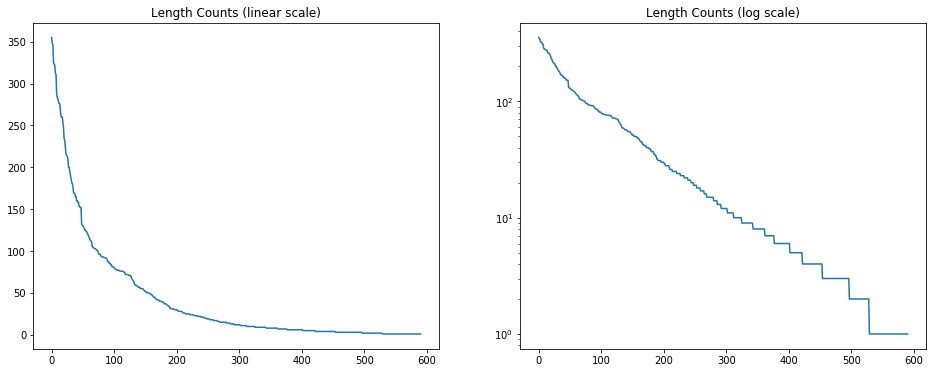

In [81]:
plot_counts(lenghts_counter, title='Length')

In [84]:
min([len(rev) for rev in reviews_tok])

4

In [89]:
train_x = np.zeros(shape=(len(reviews_tok), len(i2w)))
print(train_x.shape)

(25000, 1000)


In [96]:
train_x = np.zeros(shape=(len(reviews_tok), len(i2w)))

for i, rev in enumerate(reviews_tok):
    rrev = rev
    train_x[i, rev] = 1
    break

In [97]:
print(rrev)

[1, 195, 917, 103, 1, 8, 1, 265, 35, 1, 60, 1, 1, 355, 149, 1, 195, 1, 15, 1, 487, 1, 1, 1, 1, 1, 1, 13, 100, 1, 1, 1, 1, 116, 753, 1, 1, 560, 1, 111, 266, 1, 1, 654, 1, 265, 1, 1, 195, 234, 226, 1, 1, 5, 1, 1, 1, 1, 195, 405, 34, 1, 419, 27, 1, 195, 121, 1, 1]


In [ ]:
print

In [98]:
print('shape:', train_x.shape)
print('data:')
print(train_x[0, :100])

shape: (25000, 1000)
data:
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [104]:
words = np.nonzero(train_x[0])[0]

In [108]:
' '.join(sorted(i2w[i] for i in words))

'<UNK> age believe cartoon classic comedy episode expect far high knew lead life line many much one reality right saw school see situation think time tried whole years'

In [109]:
print(sorted(reviews_clean[0]))

['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', 'age', 'believe', 'cartoon', 'classic', 'comedy', 'episode', 'expect', 'far', 'high', 'high', 'high', 'high', 'high', 'knew', 'lead', 'life', 'line', 'many', 'much', 'one', 'reality', 'right', 'saw', 'school', 'school', 'see', 'situation', 'think', 'time', 'tried', 'whole', 'years']


In [118]:
print(sorted(list(i2w.values()))[:100])

['<PAD>', '<UNK>', 'able', 'absolutely', 'across', 'act', 'acted', 'acting', 'action', 'actor', 'actors', 'actress', 'actual', 'actually', 'add', 'admit', 'adult', 'adventure', 'age', 'ago', 'agree', 'air', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'amazing', 'america', 'american', 'among', 'amusing', 'animated', 'animation', 'annoying', 'another', 'anyone', 'anything', 'anyway', 'apart', 'apparently', 'appear', 'appears', 'appreciate', 'around', 'art', 'ask', 'atmosphere', 'attempt', 'attempts', 'attention', 'audience', 'average', 'avoid', 'away', 'awful', 'b', 'baby', 'back', 'background', 'bad', 'badly', 'band', 'based', 'basic', 'basically', 'battle', 'beautiful', 'beauty', 'became', 'become', 'becomes', 'begin', 'beginning', 'begins', 'behind', 'believable', 'believe', 'ben', 'best', 'better', 'beyond', 'big', 'biggest', 'bill', 'bit', 'black', 'blood', 'body', 'book', 'books', 'bored', 'boring', 'box', 'boy', 'boys', 'br', 'break']


In [123]:
train_y = labels_raw

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
